In [1]:
import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms

In [2]:
! ls 20190429_sims

Class0_images.h5     Class3_metadata.csv  Class7_images.h5
Class0_metadata.csv  Class4_images.h5	  Class7_metadata.csv
Class1_images.h5     Class4_metadata.csv  Class8_images.h5
Class1_metadata.csv  Class5_images.h5	  Class8_metadata.csv
Class2_images.h5     Class5_metadata.csv  Class9_images.h5
Class2_metadata.csv  Class6_images.h5	  Class9_metadata.csv
Class3_images.h5     Class6_metadata.csv  README


In [3]:
hf = h5py.File('Artifacts/CONFIGURATION_1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images = np.array(hf.get(dataset_name))
hf.close()
images.shape

(1000, 1, 64, 64)

In [4]:
image = np.arange(10,100,30)

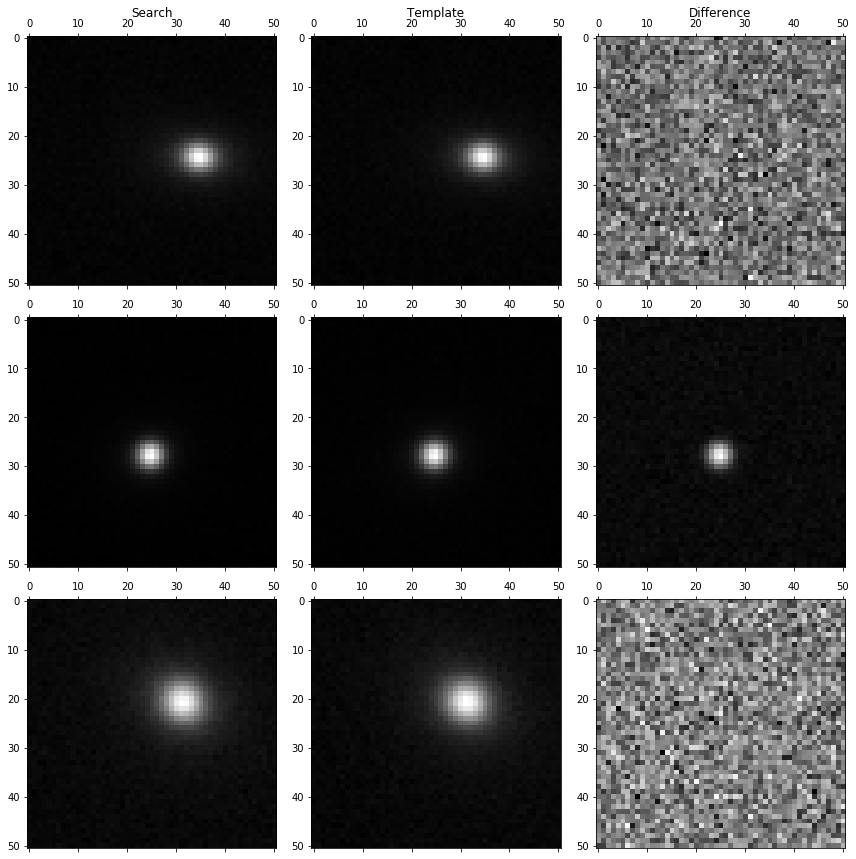

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
for i,x in enumerate(image):
    hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    for j in [0,1,2]:
        axs[i,j].matshow(images[x,j], cmap='gray');
axs[0,0].set_title('Search')
axs[0,1].set_title('Template')
axs[0,2].set_title('Difference')
fig.tight_layout()
plt.savefig('class0')

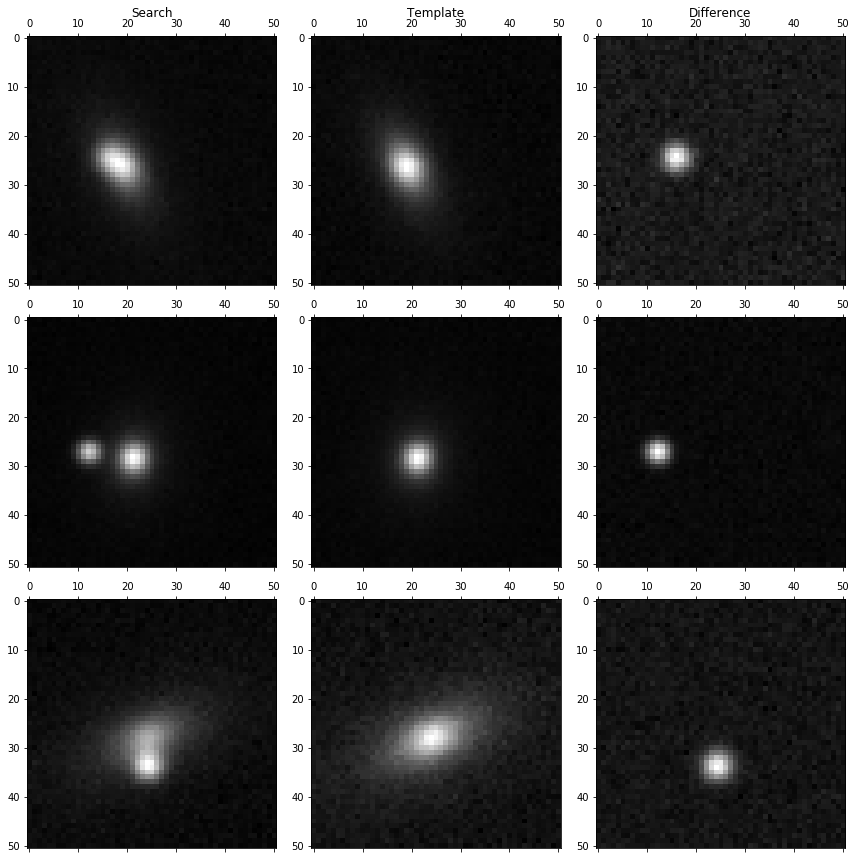

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
for i,x in enumerate(image):
    hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    for j in [0,1,2]:
        axs[i,j].matshow(images[x,j], cmap='gray');
axs[0,0].set_title('Search')
axs[0,1].set_title('Template')
axs[0,2].set_title('Difference')
fig.tight_layout()
plt.savefig('class1')

In [7]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label = sample['image'], sample['label']

        image = np.where(image_ < 10000.0, image_, 10000.0)
        scaled_array = (image - image.min()) / np.max((image - image.min()))
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label)}

In [3]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label = sample['image'], sample['label']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label)}

In [4]:
cut = 800

In [5]:
hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images0 = np.array(hf.get(dataset_name))
hf.close()
X_train0, X_test0 = images0[0:cut], images0[cut:]
y_train0, y_test0 = np.array([1] * len(X_train0)), np.array([1] * len(X_test0))

In [6]:
hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
X_train1, X_test1 = images1[0:cut], images1[cut:]
y_train1, y_test1 = np.array([1] * len(X_train1)), np.array([1] * len(X_test1))

In [7]:
hf = h5py.File('20190429_sims/Class2_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images2 = np.array(hf.get(dataset_name))
hf.close()
X_train2, X_test2 = images2[0:cut], images2[cut:]
y_train2, y_test2 = np.array([1] * len(X_train2)), np.array([1] * len(X_test2))

In [8]:
hf = h5py.File('20190429_sims/Class3_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images3 = np.array(hf.get(dataset_name))
hf.close()
X_train3, X_test3 = images3[0:cut], images3[cut:]
y_train3, y_test3 = np.array([0] * len(X_train3)), np.array([0] * len(X_test3))

In [9]:
hf = h5py.File('20190429_sims/Class4_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images4 = np.array(hf.get(dataset_name))
hf.close()
X_train4, X_test4 = images4[0:cut], images4[cut:]
y_train4, y_test4 = np.array([0] * len(X_train4)), np.array([0] * len(X_test4))

In [10]:
hf = h5py.File('20190429_sims/Class5_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images5 = np.array(hf.get(dataset_name))
hf.close()
X_train5, X_test5 = images5[0:cut], images5[cut:]
y_train5, y_test5 = np.array([0] * len(X_train5)), np.array([0] * len(X_test5))

In [11]:
hf = h5py.File('20190429_sims/Class6_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images6 = np.array(hf.get(dataset_name))
hf.close()
X_train6, X_test6 = images6[0:cut], images6[cut:]
y_train6, y_test6 = np.array([0] * len(X_train6)), np.array([0] * len(X_test6))

In [12]:
hf = h5py.File('20190429_sims/Class7_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images7 = np.array(hf.get(dataset_name))
hf.close()
X_train7, X_test7 = images7[0:cut], images7[cut:]
y_train7, y_test7 = np.array([0] * len(X_train7)), np.array([0] * len(X_test7))

In [13]:
hf = h5py.File('20190429_sims/Class8_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images8 = np.array(hf.get(dataset_name))
hf.close()
X_train8, X_test8 = images8[0:cut], images8[cut:]
y_train8, y_test8 = np.array([0] * len(X_train8)), np.array([0] * len(X_test8))

In [14]:
hf = h5py.File('20190429_sims/Class9_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images9 = np.array(hf.get(dataset_name))
hf.close()
X_train9, X_test9 = images9[0:cut], images9[cut:]
y_train9, y_test9 = np.array([0] * len(X_train9)), np.array([0] * len(X_test9))

In [15]:
X_train, X_test = np.concatenate((X_train0,X_train1,X_train2,X_train3,X_train4,X_train5,X_train6,X_train7,X_train8,X_train9)), np.concatenate((X_test0,X_test1,X_test2,X_test3,X_test4,X_test5,X_test6,X_test7,X_test8,X_test9))
y_train, y_test = np.concatenate((y_train0,y_train1,y_train2,y_train3,y_train4,y_train5,y_train6,y_train7,y_train8,y_train9)), np.concatenate((y_test0,y_test1,y_test2,y_test3,y_test4,y_test5,y_test6,y_test7,y_test8,y_test9))

In [14]:
X_train, X_test = np.concatenate((X_train0,X_train8)), np.concatenate((X_test0,X_test8))
y_train, y_test = np.concatenate((y_train0,y_train8)), np.concatenate((y_test0,y_test8))

In [16]:
def make_datasets(X_train, y_train, X_test, y_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [17]:
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test, y_test)

In [18]:
len(train_dataset)

8000

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=50176, 
                             out_features=128)
        
        self.fc2 = nn.Linear(in_features=128, 
                             out_features=3)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn = CNN()

In [20]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
number_of_training_epochs = 3
train_size = len(y_train)
validation_size = len(y_test)

In [21]:
# Append some lists as we go to track the accuracies and loss
indices, losses, train_acc, validation_acc = [], [], [], []
index_counter = 0


for epoch in range(number_of_training_epochs):
    
    for step, batch_data in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        batch_data['image'] = batch_data['image']
        
        #Get the CNN's current prediction of the training data
        output = cnn(batch_data['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, batch_data['label']) 
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
        
        #Every so often, let's print out the accuracy
        if step % 50 == 0:
            
            #Evaluate the network's predictions
            train_output = cnn(train_dataset[0:train_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
            
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()
            
            #Calculate accuracy
            train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Step: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, step, train_accuracy, validation_accuracy))
            
            #save results to list for diagnostic plots
            indices.append(index_counter)
            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)
            index_counter += 1
            

Epoch: 1 Step: 0  | Training Accuracy: 0.7 -- Validation Accuracy: 0.7
Epoch: 1 Step: 50  | Training Accuracy: 0.71475 -- Validation Accuracy: 0.722
Epoch: 1 Step: 100  | Training Accuracy: 0.8345 -- Validation Accuracy: 0.851


KeyboardInterrupt: 

In [23]:
for step, batch_data in enumerate(train_dataloader):
    print(step)

OSError: [Errno 22] Invalid argument

In [ ]:
0 to 3
Epoch: 1 Step: 0  | Training Accuracy: 0.52 -- Validation Accuracy: 0.5125
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
0 to 4
Epoch: 1 Step: 0  | Training Accuracy: 0.51375 -- Validation Accuracy: 0.5375
Epoch: 1 Step: 50  | Training Accuracy: 0.545625 -- Validation Accuracy: 0.5525
Epoch: 2 Step: 0  | Training Accuracy: 0.5925 -- Validation Accuracy: 0.595
Epoch: 2 Step: 50  | Training Accuracy: 0.65875 -- Validation Accuracy: 0.665
Epoch: 3 Step: 0  | Training Accuracy: 0.679375 -- Validation Accuracy: 0.7325
Epoch: 3 Step: 50  | Training Accuracy: 0.6225 -- Validation Accuracy: 0.6775

In [ ]:
0 to 5
Epoch: 1 Step: 0  | Training Accuracy: 0.495 -- Validation Accuracy: 0.4925
Epoch: 1 Step: 50  | Training Accuracy: 0.598125 -- Validation Accuracy: 0.62
Epoch: 2 Step: 0  | Training Accuracy: 0.67125 -- Validation Accuracy: 0.7075
Epoch: 2 Step: 50  | Training Accuracy: 0.75625 -- Validation Accuracy: 0.7825
Epoch: 3 Step: 0  | Training Accuracy: 0.7825 -- Validation Accuracy: 0.83
Epoch: 3 Step: 50  | Training Accuracy: 0.808125 -- Validation Accuracy: 0.85

In [ ]:
0 to 6
Epoch: 1 Step: 0  | Training Accuracy: 0.496875 -- Validation Accuracy: 0.4925
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
0 to 7
Epoch: 1 Step: 0  | Training Accuracy: 0.515625 -- Validation Accuracy: 0.495
Epoch: 1 Step: 50  | Training Accuracy: 0.5925 -- Validation Accuracy: 0.59
Epoch: 2 Step: 0  | Training Accuracy: 0.678125 -- Validation Accuracy: 0.7275
Epoch: 2 Step: 50  | Training Accuracy: 0.581875 -- Validation Accuracy: 0.71
Epoch: 3 Step: 0  | Training Accuracy: 0.6075 -- Validation Accuracy: 0.845
Epoch: 3 Step: 50  | Training Accuracy: 0.616875 -- Validation Accuracy: 0.9075

In [ ]:
0 to 8
Epoch: 1 Step: 0  | Training Accuracy: 0.5025 -- Validation Accuracy: 0.4875
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
0 to 9
Epoch: 1 Step: 0  | Training Accuracy: 0.503125 -- Validation Accuracy: 0.485
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
1 to 3
Epoch: 1 Step: 0  | Training Accuracy: 0.500625 -- Validation Accuracy: 0.495
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
2 to 3
Epoch: 1 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 1 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 2 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 0  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5
Epoch: 3 Step: 50  | Training Accuracy: 0.5 -- Validation Accuracy: 0.5

In [ ]:
1 to 4
Epoch: 1 Step: 0  | Training Accuracy: 0.501875 -- Validation Accuracy: 0.46
Epoch: 1 Step: 50  | Training Accuracy: 0.534375 -- Validation Accuracy: 0.49
Epoch: 2 Step: 0  | Training Accuracy: 0.539375 -- Validation Accuracy: 0.53
Epoch: 2 Step: 50  | Training Accuracy: 0.528125 -- Validation Accuracy: 0.5325
Epoch: 3 Step: 0  | Training Accuracy: 0.77875 -- Validation Accuracy: 0.7875
Epoch: 3 Step: 50  | Training Accuracy: 0.746875 -- Validation Accuracy: 0.7525

In [9]:
hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images0 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images0 < 10000.0, images0, 10000.0)
images0 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images1 < 10000.0, images1, 10000.0)
images1 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class2_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images2 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images2 < 10000.0, images2, 10000.0)
images2 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class3_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images3 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images3 < 10000.0, images3, 10000.0)
images3 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class4_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images4 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images4 < 10000.0, images4, 10000.0)
images4 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class5_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images5 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images5 < 10000.0, images5, 10000.0)
images5 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class6_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images6 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images6 < 10000.0, images6, 10000.0)
images6 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class7_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images7 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images7 < 10000.0, images7, 10000.0)
images7 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class8_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images8 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images8 < 10000.0, images8, 10000.0)
images8 = (image - image.min()) / np.max((image - image.min()))

hf = h5py.File('20190429_sims/Class9_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images9 = np.array(hf.get(dataset_name))
hf.close()
image = np.where(images9 < 10000.0, images9, 10000.0)
images9 = (image - image.min()) / np.max((image - image.min()))

In [9]:
hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images0 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images0))
images0 = (images0 - np.mean(images0) + 0.5)/(10*np.std(images0))

hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images1))
images1 = (images1 - np.mean(images1) + 0.5)/(10*np.std(images1))

hf = h5py.File('20190429_sims/Class2_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images2 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images2))
images2 = (images2 - np.mean(images2) + 0.5)/(10*np.std(images2))

hf = h5py.File('20190429_sims/Class3_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images3 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images3))
images3 = (images3 - np.mean(images3) + 0.5)/(10*np.std(images3))

hf = h5py.File('20190429_sims/Class4_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images4 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images4))
images4 = (images4 - np.mean(images4) + 0.5)/(10*np.std(images4))

hf = h5py.File('20190429_sims/Class5_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images5 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images5))
images5 = (images5 - np.mean(images5) + 0.5)/(10*np.std(images5))

hf = h5py.File('20190429_sims/Class6_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images6 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images6))
images6 = (images6 - np.mean(images6) + 0.5)/(10*np.std(images6))

hf = h5py.File('20190429_sims/Class7_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images7 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images7))
images7 = (images7 - np.mean(images7) + 0.5)/(10*np.std(images7))

hf = h5py.File('20190429_sims/Class8_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images8 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images8))
images8 = (images8 - np.mean(images8) + 0.5)/(10*np.std(images8))

hf = h5py.File('20190429_sims/Class9_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images9 = np.array(hf.get(dataset_name))
hf.close()
print(np.std(images9))
images9 = (images9 - np.mean(images9) + 0.5)/(10*np.std(images9))

13358.281130836249
5388.576017298293
5421.454263249918
16753.91618343007
5912.249898356835
5082.6978746624545
5113.8009778948635
5773.927127568644
5460.918297083578
5600.164013722557


In [182]:
hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images0 = np.array(hf.get(dataset_name))
hf.close()
images0 = (images0 - np.mean(images0,axis=(2,3),keepdims=True))/(10*np.std(images0,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
images1 = (images1 - np.mean(images1,axis=(2,3),keepdims=True))/(10*np.std(images1,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class2_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images2 = np.array(hf.get(dataset_name))
hf.close()
images2 = (images2 - np.mean(images2,axis=(2,3),keepdims=True))/(10*np.std(images2,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class3_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images3 = np.array(hf.get(dataset_name))
hf.close()
images3 = (images3 - np.mean(images3,axis=(2,3),keepdims=True))/(10*np.std(images3,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class4_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images4 = np.array(hf.get(dataset_name))
hf.close()
images4 = (images4 - np.mean(images4,axis=(2,3),keepdims=True))/(10*np.std(images4,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class5_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images5 = np.array(hf.get(dataset_name))
hf.close()
images5 = (images5 - np.mean(images5,axis=(2,3),keepdims=True))/(10*np.std(images5,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class6_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images6 = np.array(hf.get(dataset_name))
hf.close()
images6 = (images6 - np.mean(images6,axis=(2,3),keepdims=True))/(10*np.std(images6,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class7_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images7 = np.array(hf.get(dataset_name))
hf.close()
images7 = (images7 - np.mean(images7,axis=(2,3),keepdims=True))/(10*np.std(images7,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class8_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images8 = np.array(hf.get(dataset_name))
hf.close()
images8 = (images8 - np.mean(images8,axis=(2,3),keepdims=True))/(10*np.std(images8,axis=(2,3),keepdims=True)) + 0.5

hf = h5py.File('20190429_sims/Class9_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images9 = np.array(hf.get(dataset_name))
hf.close()
images9 = (images9 - np.mean(images9,axis=(2,3),keepdims=True))/(10*np.std(images9,axis=(2,3),keepdims=True)) + 0.5

In [100]:
print(np.mean(images0))
print(np.mean(images1))
print(np.mean(images2))
print(np.mean(images3))
print(np.mean(images4))
print(np.mean(images5))
print(np.mean(images6))
print(np.mean(images7))
print(np.mean(images8))
print(np.mean(images9))


0.5000000000000003
0.5000000000000007
0.4999999999999999
0.5000000000000007
0.4999999999999994
0.5000000000000007
0.49999999999999983
0.4999999999999991
0.5000000000000001
0.4999999999999993


In [131]:
np.mean(images4[:,1,:,:])

0.5000000000000001

In [101]:
print(np.std(images0))
print(np.std(images1))
print(np.std(images2))
print(np.std(images3))
print(np.std(images4))
print(np.std(images5))
print(np.std(images6))
print(np.std(images7))
print(np.std(images8))
print(np.std(images9))

0.10000000000000005
0.09999999999999994
0.09999999999999999
0.10000000000000002
0.1
0.10000000000000003
0.09999999999999996
0.09999999999999999
0.10000000000000003
0.1


In [345]:
hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
images1 = images1 - np.mean(images1,axis=(2,3),keepdims=True)
np.shape(images1)

(1000, 3, 51, 51)

In [11]:
hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
print(np.mean(images1 - np.mean(images1) + 0.5))
print(np.std(images1))
images1 = (images1 - np.mean(images1) + 0.5)/(10*np.std(images1))
np.std(images1)

0.5000000000019655
5388.576017298293


0.09999999999999996

In [6]:
hf = h5py.File('20190429_sims/Class9_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images9 = np.array(hf.get(dataset_name))
hf.close()
np.mean((images9 - np.mean(images9,axis=(2,3),keepdims=True))/(np.std(images9,axis=(2,3),keepdims=True)))

-1.2504386578825703e-17

In [5]:
hf = h5py.File('20190429_sims/Class7_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images7 = np.array(hf.get(dataset_name))
hf.close()
np.mean((images7 - np.mean(images7,axis=(2,3),keepdims=True))/(np.std(images7,axis=(2,3),keepdims=True))

9.712845106640437e-17

In [78]:
from sklearn import preprocessing
hf = h5py.File('20190429_sims/Class0_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images0 = np.array(hf.get(dataset_name))
hf.close()
#images0 = preprocessing.scale(images0)
np.shape(images0[1,1,:,:])

(51, 51)

In [176]:
hf = h5py.File('20190429_sims/Class1_images.h5', 'r')
dataset_name = list(hf.keys())[0]
images1 = np.array(hf.get(dataset_name))
hf.close()
images0 = (images0 - np.mean(images0,axis=(2,3),keepdims=True))/(10*np.std(images0,axis=(2,3),keepdims=True))

In [173]:
x = [14,1003,432,8001,7535]
print(x)
print(np.mean(x))
print(np.std(x))
print(np.mean((x-np.mean(x))/(10*np.std(x))))
print(np.std((x-np.mean(x))/(10*np.std(x))))

[14, 1003, 432, 8001, 7535]
3397.0
3585.7219635660545
-8.326672684688674e-18
0.09999999999999999


# Median

In [183]:
class_0_search_medians = np.median(images0[:,0,:,:], axis=(-1, -2))
class_0_template_medians = np.median(images0[:,1,:,:], axis=(-1, -2))
class_0_difference_medians = np.median(images0[:,2,:,:], axis=(-1, -2))

class_1_search_medians = np.median(images1[:,0,:,:], axis=(-1, -2))
class_1_template_medians = np.median(images1[:,1,:,:], axis=(-1, -2))
class_1_difference_medians = np.median(images1[:,2,:,:], axis=(-1, -2))

class_2_search_medians = np.median(images2[:,0,:,:], axis=(-1, -2))
class_2_template_medians = np.median(images2[:,1,:,:], axis=(-1, -2))
class_2_difference_medians = np.median(images2[:,2,:,:], axis=(-1, -2))

class_3_search_medians = np.median(images3[:,0,:,:], axis=(-1, -2))
class_3_template_medians = np.median(images3[:,1,:,:], axis=(-1, -2))
class_3_difference_medians = np.median(images3[:,2,:,:], axis=(-1, -2))

class_4_search_medians = np.median(images4[:,0,:,:], axis=(-1, -2))
class_4_template_medians = np.median(images4[:,1,:,:], axis=(-1, -2))
class_4_difference_medians = np.median(images4[:,2,:,:], axis=(-1, -2))

class_5_search_medians = np.median(images5[:,0,:,:], axis=(-1, -2))
class_5_template_medians = np.median(images5[:,1,:,:], axis=(-1, -2))
class_5_difference_medians = np.median(images5[:,2,:,:], axis=(-1, -2))

class_6_search_medians = np.median(images6[:,0,:,:], axis=(-1, -2))
class_6_template_medians = np.median(images6[:,1,:,:], axis=(-1, -2))
class_6_difference_medians = np.median(images6[:,2,:,:], axis=(-1, -2))

class_7_search_medians = np.median(images7[:,0,:,:], axis=(-1, -2))
class_7_template_medians = np.median(images7[:,1,:,:], axis=(-1, -2))
class_7_difference_medians = np.median(images7[:,2,:,:], axis=(-1, -2))

class_8_search_medians = np.median(images8[:,0,:,:], axis=(-1, -2))
class_8_template_medians = np.median(images8[:,1,:,:], axis=(-1, -2))
class_8_difference_medians = np.median(images8[:,2,:,:], axis=(-1, -2))

class_9_search_medians = np.median(images9[:,0,:,:], axis=(-1, -2))
class_9_template_medians = np.median(images9[:,1,:,:], axis=(-1, -2))
class_9_difference_medians = np.median(images9[:,2,:,:], axis=(-1, -2))

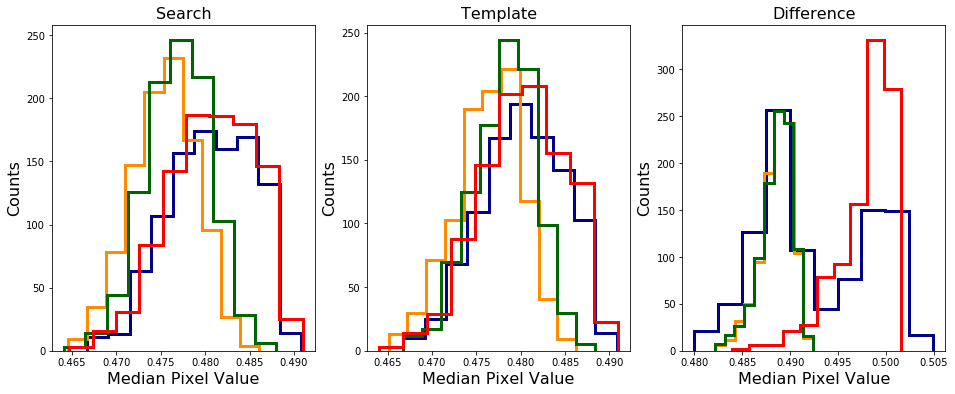

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_medians, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[0].hist(class_1_search_medians, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[0].hist(class_2_search_medians, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[0].hist(class_3_search_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Median Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_medians, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[1].hist(class_1_template_medians, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[1].hist(class_2_template_medians, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[1].hist(class_3_template_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Median Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_medians, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_medians, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[2].hist(class_2_difference_medians, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[2].hist(class_3_difference_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Median Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

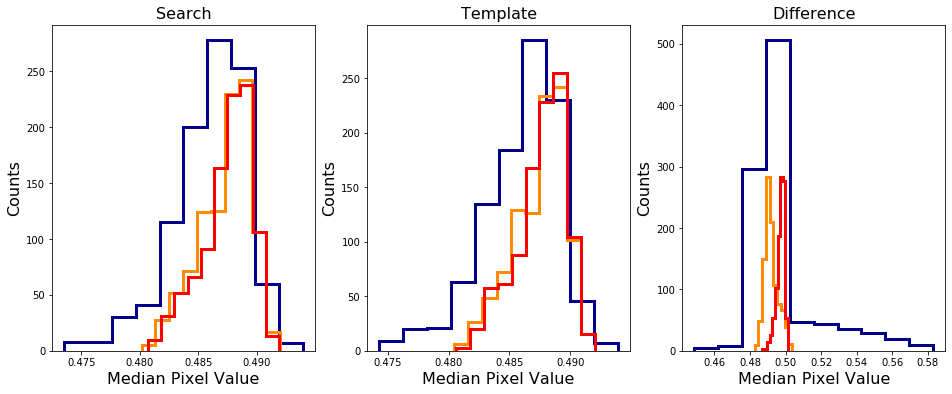

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_4_search_medians, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[0].hist(class_5_search_medians, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[0].hist(class_6_search_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Median Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_4_template_medians, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[1].hist(class_5_template_medians, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[1].hist(class_6_template_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Median Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_4_difference_medians, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_medians, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[2].hist(class_6_difference_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Median Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

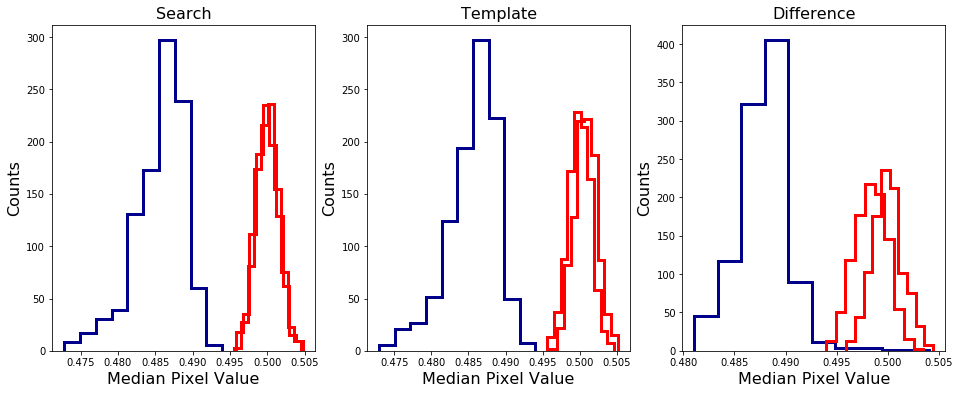

In [186]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_7_search_medians, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[0].hist(class_8_search_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Median Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_7_template_medians, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[1].hist(class_8_template_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Median Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_7_difference_medians, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Median Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

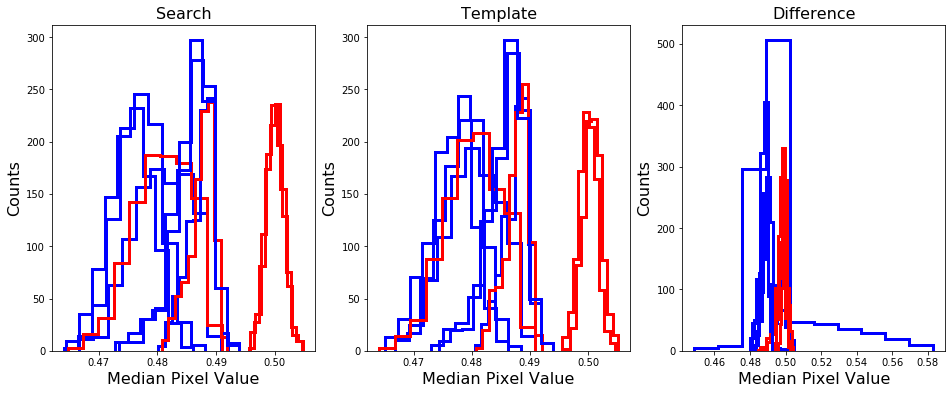

In [187]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_medians, histtype='step', color='blue', label='Class 0', lw=3)
axs[0].hist(class_1_search_medians, histtype='step', color='blue', label='Class 1', lw=3)
axs[0].hist(class_2_search_medians, histtype='step', color='blue', label='Class 2', lw=3)
axs[0].hist(class_3_search_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[0].hist(class_4_search_medians, histtype='step', color='blue', label='Class 4', lw=3)
axs[0].hist(class_5_search_medians, histtype='step', color='blue', label='Class 5', lw=3)
axs[0].hist(class_6_search_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[0].hist(class_7_search_medians, histtype='step', color='blue', label='Class 7', lw=3)
axs[0].hist(class_8_search_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Median Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_medians, histtype='step', color='blue', label='Class 0', lw=3)
axs[1].hist(class_1_template_medians, histtype='step', color='blue', label='Class 1', lw=3)
axs[1].hist(class_2_template_medians, histtype='step', color='blue', label='Class 2', lw=3)
axs[1].hist(class_3_template_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[1].hist(class_4_template_medians, histtype='step', color='blue', label='Class 4', lw=3)
axs[1].hist(class_5_template_medians, histtype='step', color='blue', label='Class 5', lw=3)
axs[1].hist(class_6_template_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[1].hist(class_7_template_medians, histtype='step', color='blue', label='Class 7', lw=3)
axs[1].hist(class_8_template_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Median Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_medians, histtype='step', color='blue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_medians, histtype='step', color='blue', label='Class 1', lw=3)
axs[2].hist(class_2_difference_medians, histtype='step', color='blue', label='Class 2', lw=3)
axs[2].hist(class_3_difference_medians, histtype='step', color='red', label='Class 3', lw=3)
axs[2].hist(class_4_difference_medians, histtype='step', color='blue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_medians, histtype='step', color='blue', label='Class 5', lw=3)
axs[2].hist(class_6_difference_medians, histtype='step', color='red', label='Class 6', lw=3)
axs[2].hist(class_7_difference_medians, histtype='step', color='blue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_medians, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_medians, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Median Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

## Maximum

In [188]:
class_0_search_max = np.max(images0[:,0,:,:], axis=(-1, -2))
class_0_template_max = np.max(images0[:,1,:,:], axis=(-1, -2))
class_0_difference_max = np.max(images0[:,2,:,:], axis=(-1, -2))

class_1_search_max = np.max(images1[:,0,:,:], axis=(-1, -2))
class_1_template_max = np.max(images1[:,1,:,:], axis=(-1, -2))
class_1_difference_max = np.max(images1[:,2,:,:], axis=(-1, -2))

class_2_search_max = np.max(images2[:,0,:,:], axis=(-1, -2))
class_2_template_max = np.max(images2[:,1,:,:], axis=(-1, -2))
class_2_difference_max = np.max(images2[:,2,:,:], axis=(-1, -2))

class_3_search_max = np.max(images3[:,0,:,:], axis=(-1, -2))
class_3_template_max = np.max(images3[:,1,:,:], axis=(-1, -2))
class_3_difference_max = np.max(images3[:,2,:,:], axis=(-1, -2))

class_4_search_max = np.max(images4[:,0,:,:], axis=(-1, -2))
class_4_template_max = np.max(images4[:,1,:,:], axis=(-1, -2))
class_4_difference_max = np.max(images4[:,2,:,:], axis=(-1, -2))

class_5_search_max = np.max(images5[:,0,:,:], axis=(-1, -2))
class_5_template_max = np.max(images5[:,1,:,:], axis=(-1, -2))
class_5_difference_max = np.max(images5[:,2,:,:], axis=(-1, -2))

class_6_search_max = np.max(images6[:,0,:,:], axis=(-1, -2))
class_6_template_max = np.max(images6[:,1,:,:], axis=(-1, -2))
class_6_difference_max = np.max(images6[:,2,:,:], axis=(-1, -2))

class_7_search_max = np.max(images7[:,0,:,:], axis=(-1, -2))
class_7_template_max = np.max(images7[:,1,:,:], axis=(-1, -2))
class_7_difference_max = np.max(images7[:,2,:,:], axis=(-1, -2))

class_8_search_max = np.max(images8[:,0,:,:], axis=(-1, -2))
class_8_template_max = np.max(images8[:,1,:,:], axis=(-1, -2))
class_8_difference_max = np.max(images8[:,2,:,:], axis=(-1, -2))

class_9_search_max = np.max(images9[:,0,:,:], axis=(-1, -2))
class_9_template_max = np.max(images9[:,1,:,:], axis=(-1, -2))
class_9_difference_max = np.max(images9[:,2,:,:], axis=(-1, -2))

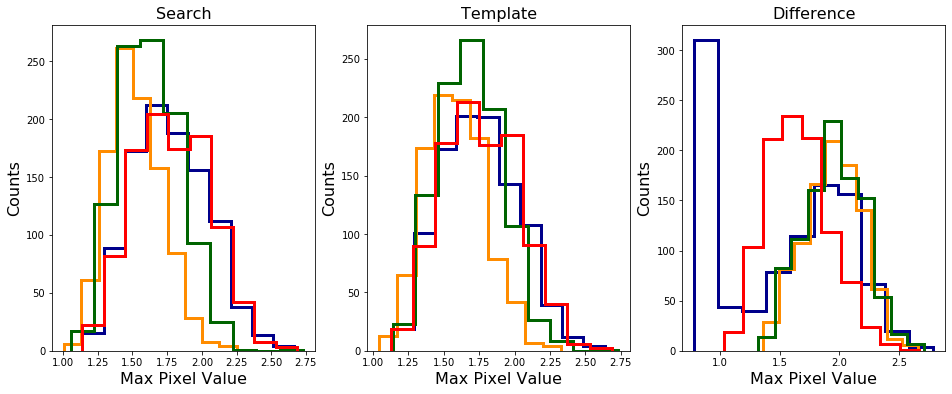

In [189]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_max, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[0].hist(class_1_search_max, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[0].hist(class_2_search_max, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[0].hist(class_3_search_max, histtype='step', color='red', label='Class 3', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Max Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_max, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[1].hist(class_1_template_max, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[1].hist(class_2_template_max, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[1].hist(class_3_template_max, histtype='step', color='red', label='Class 3', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Max Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_max, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_max, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[2].hist(class_2_difference_max, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[2].hist(class_3_difference_max, histtype='step', color='red', label='Class 3', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Max Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

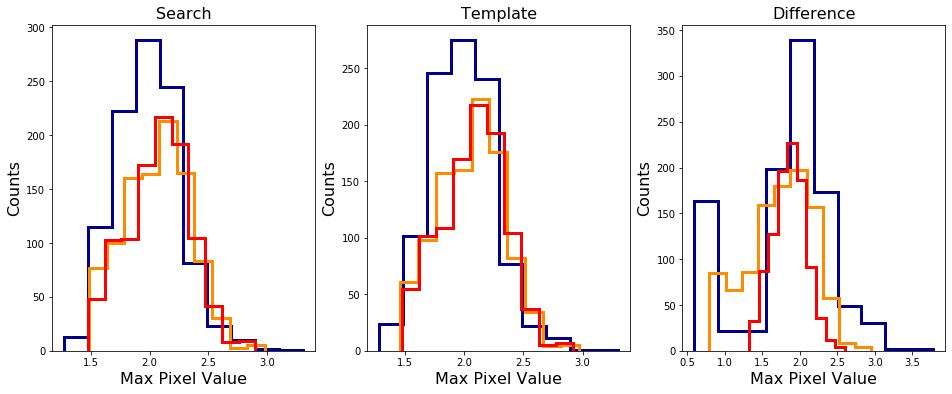

In [190]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_4_search_max, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[0].hist(class_5_search_max, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[0].hist(class_6_search_max, histtype='step', color='red', label='Class 6', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Max Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_4_template_max, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[1].hist(class_5_template_max, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[1].hist(class_6_template_max, histtype='step', color='red', label='Class 6', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Max Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_4_difference_max, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_max, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[2].hist(class_6_difference_max, histtype='step', color='red', label='Class 6', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Max Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

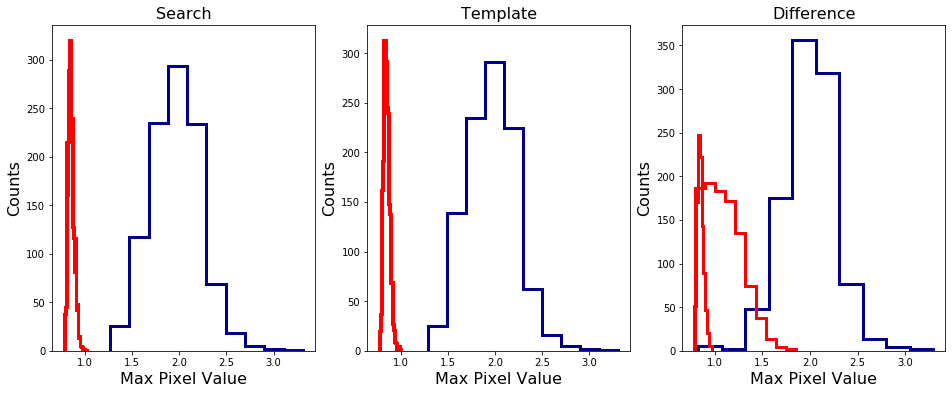

In [191]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_7_search_max, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[0].hist(class_8_search_max, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_max, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Max Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_7_template_max, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[1].hist(class_8_template_max, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_max, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Max Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_7_difference_max, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_max, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_max, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Max Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

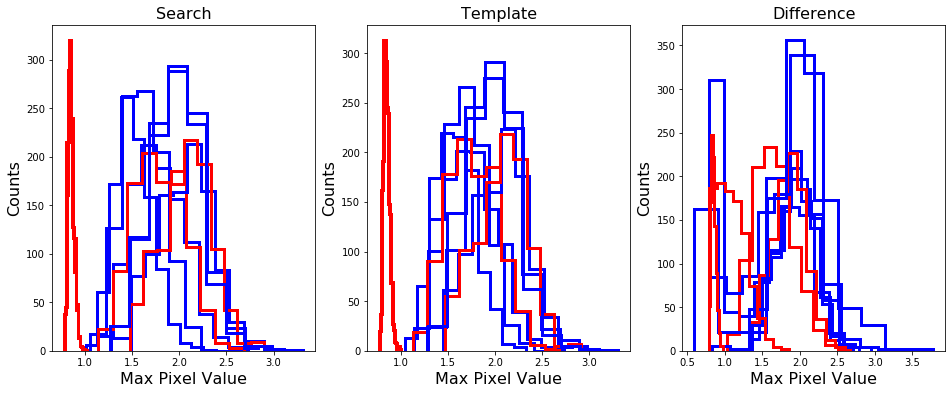

In [192]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_max, histtype='step', color='blue', label='Class 0', lw=3)
axs[0].hist(class_1_search_max, histtype='step', color='blue', label='Class 1', lw=3)
axs[0].hist(class_2_search_max, histtype='step', color='blue', label='Class 2', lw=3)
axs[0].hist(class_3_search_max, histtype='step', color='red', label='Class 3', lw=3)
axs[0].hist(class_4_search_max, histtype='step', color='blue', label='Class 4', lw=3)
axs[0].hist(class_5_search_max, histtype='step', color='blue', label='Class 5', lw=3)
axs[0].hist(class_6_search_max, histtype='step', color='red', label='Class 6', lw=3)
axs[0].hist(class_7_search_max, histtype='step', color='blue', label='Class 7', lw=3)
axs[0].hist(class_8_search_max, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_max, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Max Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_max, histtype='step', color='blue', label='Class 0', lw=3)
axs[1].hist(class_1_template_max, histtype='step', color='blue', label='Class 1', lw=3)
axs[1].hist(class_2_template_max, histtype='step', color='blue', label='Class 2', lw=3)
axs[1].hist(class_3_template_max, histtype='step', color='red', label='Class 3', lw=3)
axs[1].hist(class_4_template_max, histtype='step', color='blue', label='Class 4', lw=3)
axs[1].hist(class_5_template_max, histtype='step', color='blue', label='Class 5', lw=3)
axs[1].hist(class_6_template_max, histtype='step', color='red', label='Class 6', lw=3)
axs[1].hist(class_7_template_max, histtype='step', color='blue', label='Class 7', lw=3)
axs[1].hist(class_8_template_max, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_max, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Max Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_max, histtype='step', color='blue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_max, histtype='step', color='blue', label='Class 1', lw=3)
axs[2].hist(class_2_difference_max, histtype='step', color='blue', label='Class 2', lw=3)
axs[2].hist(class_3_difference_max, histtype='step', color='red', label='Class 3', lw=3)
axs[2].hist(class_4_difference_max, histtype='step', color='blue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_max, histtype='step', color='blue', label='Class 5', lw=3)
axs[2].hist(class_6_difference_max, histtype='step', color='red', label='Class 6', lw=3)
axs[2].hist(class_7_difference_max, histtype='step', color='blue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_max, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_max, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Max Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

## Minimum

In [193]:
class_0_search_min = np.min(images0[:,0,:,:], axis=(-1, -2))
class_0_template_min = np.min(images0[:,1,:,:], axis=(-1, -2))
class_0_difference_min = np.min(images0[:,2,:,:], axis=(-1, -2))

class_1_search_min = np.min(images1[:,0,:,:], axis=(-1, -2))
class_1_template_min = np.min(images1[:,1,:,:], axis=(-1, -2))
class_1_difference_min = np.min(images1[:,2,:,:], axis=(-1, -2))

class_2_search_min = np.min(images2[:,0,:,:], axis=(-1, -2))
class_2_template_min = np.min(images2[:,1,:,:], axis=(-1, -2))
class_2_difference_min = np.min(images2[:,2,:,:], axis=(-1, -2))

class_3_search_min = np.min(images3[:,0,:,:], axis=(-1, -2))
class_3_template_min = np.min(images3[:,1,:,:], axis=(-1, -2))
class_3_difference_min = np.min(images3[:,2,:,:], axis=(-1, -2))

class_4_search_min = np.min(images4[:,0,:,:], axis=(-1, -2))
class_4_template_min = np.min(images4[:,1,:,:], axis=(-1, -2))
class_4_difference_min = np.min(images4[:,2,:,:], axis=(-1, -2))

class_5_search_min = np.min(images5[:,0,:,:], axis=(-1, -2))
class_5_template_min = np.min(images5[:,1,:,:], axis=(-1, -2))
class_5_difference_min = np.min(images5[:,2,:,:], axis=(-1, -2))

class_6_search_min = np.min(images6[:,0,:,:], axis=(-1, -2))
class_6_template_min = np.min(images6[:,1,:,:], axis=(-1, -2))
class_6_difference_min = np.min(images6[:,2,:,:], axis=(-1, -2))

class_7_search_min = np.min(images7[:,0,:,:], axis=(-1, -2))
class_7_template_min = np.min(images7[:,1,:,:], axis=(-1, -2))
class_7_difference_min = np.min(images7[:,2,:,:], axis=(-1, -2))

class_8_search_min = np.min(images8[:,0,:,:], axis=(-1, -2))
class_8_template_min = np.min(images8[:,1,:,:], axis=(-1, -2))
class_8_difference_min = np.min(images8[:,2,:,:], axis=(-1, -2))

class_9_search_min = np.min(images9[:,0,:,:], axis=(-1, -2))
class_9_template_min = np.min(images9[:,1,:,:], axis=(-1, -2))
class_9_difference_min = np.min(images9[:,2,:,:], axis=(-1, -2))

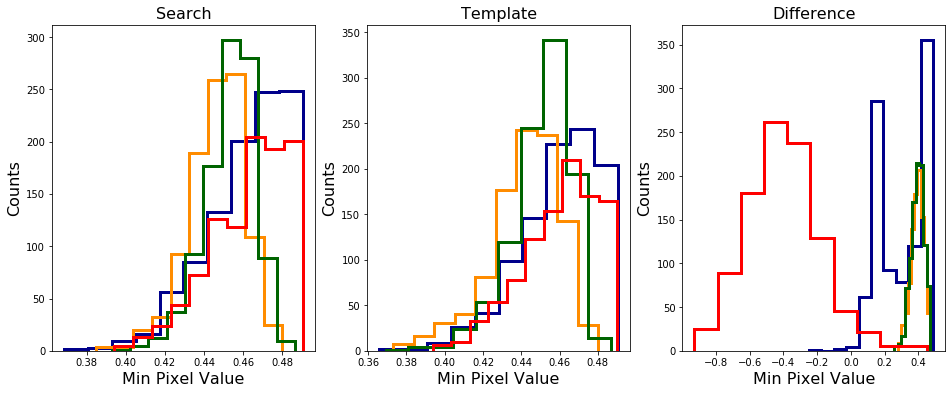

In [194]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_min, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[0].hist(class_1_search_min, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[0].hist(class_2_search_min, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[0].hist(class_3_search_min, histtype='step', color='red', label='Class 3', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Min Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_min, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[1].hist(class_1_template_min, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[1].hist(class_2_template_min, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[1].hist(class_3_template_min, histtype='step', color='red', label='Class 3', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Min Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_min, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_min, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[2].hist(class_2_difference_min, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[2].hist(class_3_difference_min, histtype='step', color='red', label='Class 3', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Min Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

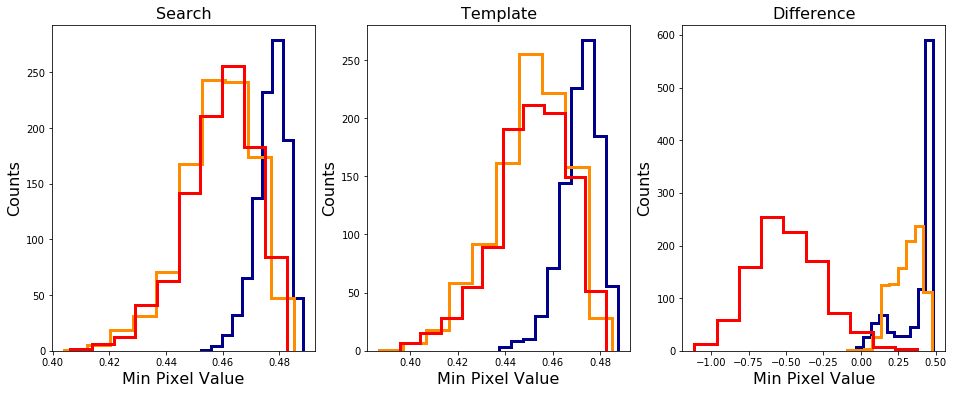

In [195]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_4_search_min, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[0].hist(class_5_search_min, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[0].hist(class_6_search_min, histtype='step', color='red', label='Class 6', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Min Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_4_template_min, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[1].hist(class_5_template_min, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[1].hist(class_6_template_min, histtype='step', color='red', label='Class 6', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Min Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_4_difference_min, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_min, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[2].hist(class_6_difference_min, histtype='step', color='red', label='Class 6', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Min Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

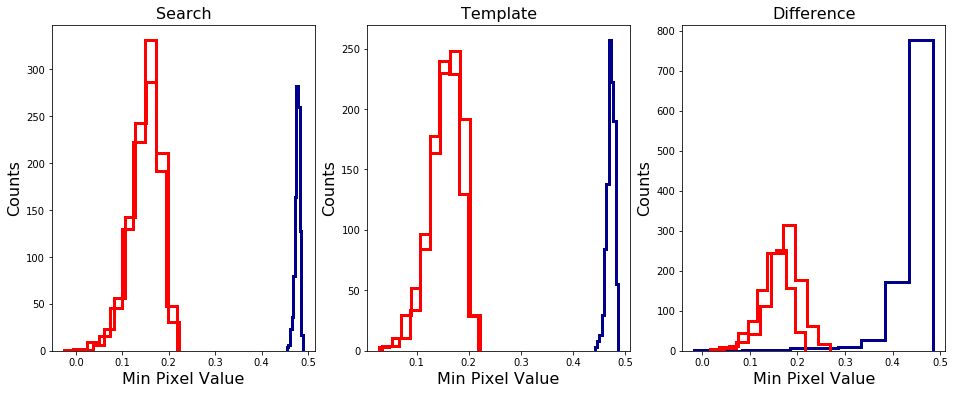

In [196]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_7_search_min, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[0].hist(class_8_search_min, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_min, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Min Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_7_template_min, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[1].hist(class_8_template_min, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_min, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Min Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_7_difference_min, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_min, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_min, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Min Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

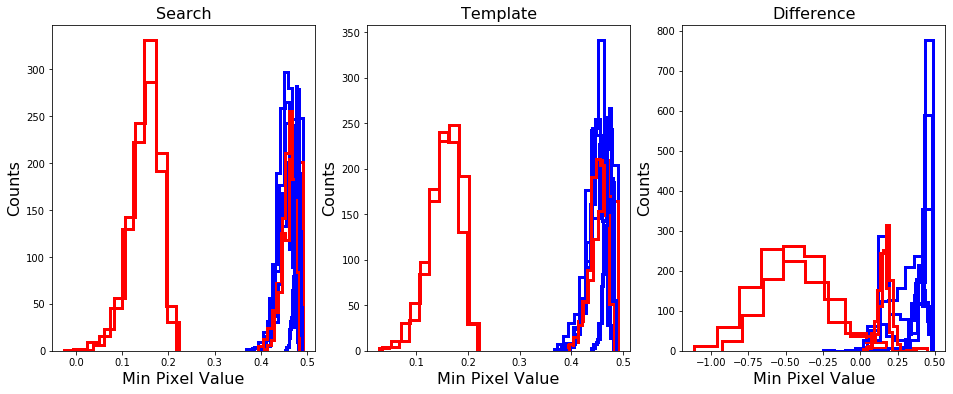

In [197]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_min, histtype='step', color='blue', label='Class 0', lw=3)
axs[0].hist(class_1_search_min, histtype='step', color='blue', label='Class 1', lw=3)
axs[0].hist(class_2_search_min, histtype='step', color='blue', label='Class 2', lw=3)
axs[0].hist(class_3_search_min, histtype='step', color='red', label='Class 3', lw=3)
axs[0].hist(class_4_search_min, histtype='step', color='blue', label='Class 4', lw=3)
axs[0].hist(class_5_search_min, histtype='step', color='blue', label='Class 5', lw=3)
axs[0].hist(class_6_search_min, histtype='step', color='red', label='Class 6', lw=3)
axs[0].hist(class_7_search_min, histtype='step', color='blue', label='Class 7', lw=3)
axs[0].hist(class_8_search_min, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_min, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Min Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_min, histtype='step', color='blue', label='Class 0', lw=3)
axs[1].hist(class_1_template_min, histtype='step', color='blue', label='Class 1', lw=3)
axs[1].hist(class_2_template_min, histtype='step', color='blue', label='Class 2', lw=3)
axs[1].hist(class_3_template_min, histtype='step', color='red', label='Class 3', lw=3)
axs[1].hist(class_4_template_min, histtype='step', color='blue', label='Class 4', lw=3)
axs[1].hist(class_5_template_min, histtype='step', color='blue', label='Class 5', lw=3)
axs[1].hist(class_6_template_min, histtype='step', color='red', label='Class 6', lw=3)
axs[1].hist(class_7_template_min, histtype='step', color='blue', label='Class 7', lw=3)
axs[1].hist(class_8_template_min, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_min, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Min Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_min, histtype='step', color='blue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_min, histtype='step', color='blue', label='Class 1', lw=3)
axs[2].hist(class_2_difference_min, histtype='step', color='blue', label='Class 2', lw=3)
axs[2].hist(class_3_difference_min, histtype='step', color='red', label='Class 3', lw=3)
axs[2].hist(class_4_difference_min, histtype='step', color='blue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_min, histtype='step', color='blue', label='Class 5', lw=3)
axs[2].hist(class_6_difference_min, histtype='step', color='red', label='Class 6', lw=3)
axs[2].hist(class_7_difference_min, histtype='step', color='blue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_min, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_min, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Min Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

# Mean

In [198]:
class_0_search_mean = np.mean(images0[:,0,:,:], axis=(-1, -2))
class_0_template_mean = np.mean(images0[:,1,:,:], axis=(-1, -2))
class_0_difference_mean = np.mean(images0[:,2,:,:], axis=(-1, -2))

class_1_search_mean = np.mean(images1[:,0,:,:], axis=(-1, -2))
class_1_template_mean = np.mean(images1[:,1,:,:], axis=(-1, -2))
class_1_difference_mean = np.mean(images1[:,2,:,:], axis=(-1, -2))

class_2_search_mean = np.mean(images2[:,0,:,:], axis=(-1, -2))
class_2_template_mean = np.mean(images2[:,1,:,:], axis=(-1, -2))
class_2_difference_mean = np.mean(images2[:,2,:,:], axis=(-1, -2))

class_3_search_mean = np.mean(images3[:,0,:,:], axis=(-1, -2))
class_3_template_mean = np.mean(images3[:,1,:,:], axis=(-1, -2))
class_3_difference_mean = np.mean(images3[:,2,:,:], axis=(-1, -2))

class_4_search_mean = np.mean(images4[:,0,:,:], axis=(-1, -2))
class_4_template_mean = np.mean(images4[:,1,:,:], axis=(-1, -2))
class_4_difference_mean = np.mean(images4[:,2,:,:], axis=(-1, -2))

class_5_search_mean = np.mean(images5[:,0,:,:], axis=(-1, -2))
class_5_template_mean = np.mean(images5[:,1,:,:], axis=(-1, -2))
class_5_difference_mean = np.mean(images5[:,2,:,:], axis=(-1, -2))

class_6_search_mean = np.mean(images6[:,0,:,:], axis=(-1, -2))
class_6_template_mean = np.mean(images6[:,1,:,:], axis=(-1, -2))
class_6_difference_mean = np.mean(images6[:,2,:,:], axis=(-1, -2))

class_7_search_mean = np.mean(images7[:,0,:,:], axis=(-1, -2))
class_7_template_mean = np.mean(images7[:,1,:,:], axis=(-1, -2))
class_7_difference_mean = np.mean(images7[:,2,:,:], axis=(-1, -2))

class_8_search_mean = np.mean(images8[:,0,:,:], axis=(-1, -2))
class_8_template_mean = np.mean(images8[:,1,:,:], axis=(-1, -2))
class_8_difference_mean = np.mean(images8[:,2,:,:], axis=(-1, -2))

class_9_search_mean = np.mean(images9[:,0,:,:], axis=(-1, -2))
class_9_template_mean = np.mean(images9[:,1,:,:], axis=(-1, -2))
class_9_difference_mean = np.mean(images9[:,2,:,:], axis=(-1, -2))

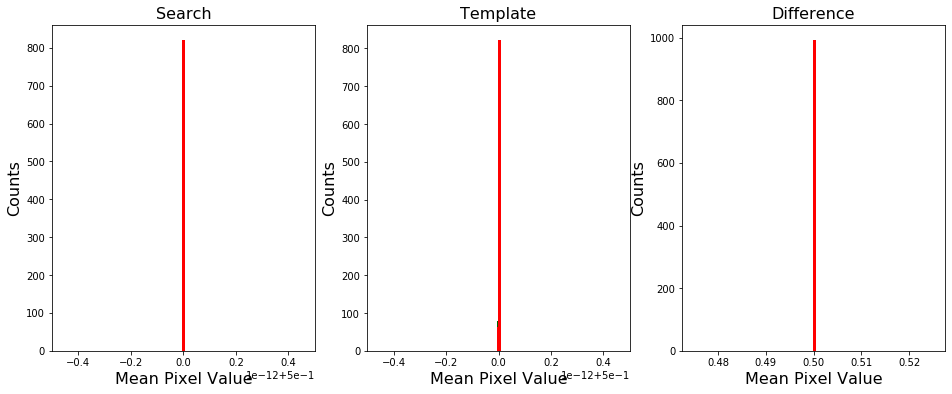

In [199]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_mean, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[0].hist(class_1_search_mean, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[0].hist(class_2_search_mean, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[0].hist(class_3_search_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Mean Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_mean, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[1].hist(class_1_template_mean, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[1].hist(class_2_template_mean, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[1].hist(class_3_template_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Mean Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_mean, histtype='step', color='darkblue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_mean, histtype='step', color='darkorange', label='Class 1', lw=3)
axs[2].hist(class_2_difference_mean, histtype='step', color='darkgreen', label='Class 2', lw=3)
axs[2].hist(class_3_difference_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Mean Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

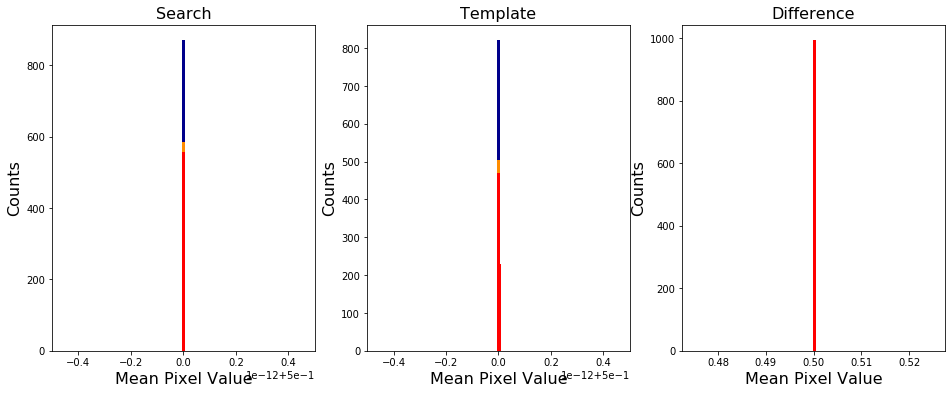

In [200]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_4_search_mean, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[0].hist(class_5_search_mean, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[0].hist(class_6_search_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Mean Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_4_template_mean, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[1].hist(class_5_template_mean, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[1].hist(class_6_template_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Mean Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_4_difference_mean, histtype='step', color='darkblue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_mean, histtype='step', color='darkorange', label='Class 5', lw=3)
axs[2].hist(class_6_difference_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Mean Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

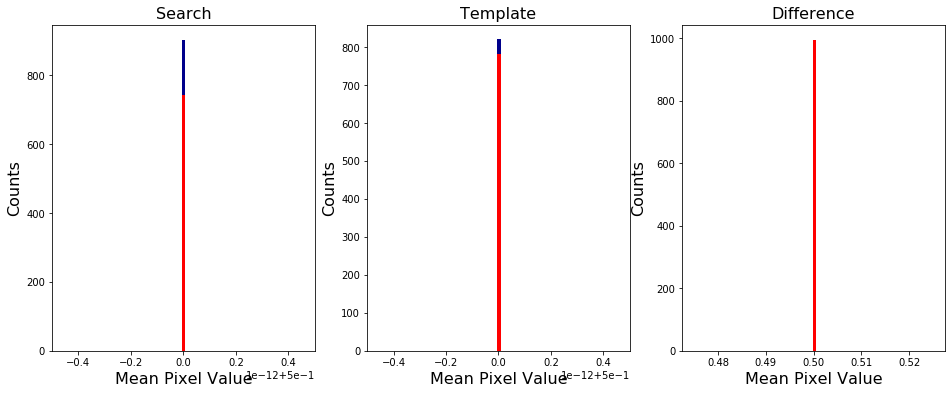

In [201]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_7_search_mean, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[0].hist(class_8_search_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Mean Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_7_template_mean, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[1].hist(class_8_template_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Mean Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_7_difference_mean, histtype='step', color='darkblue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Mean Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

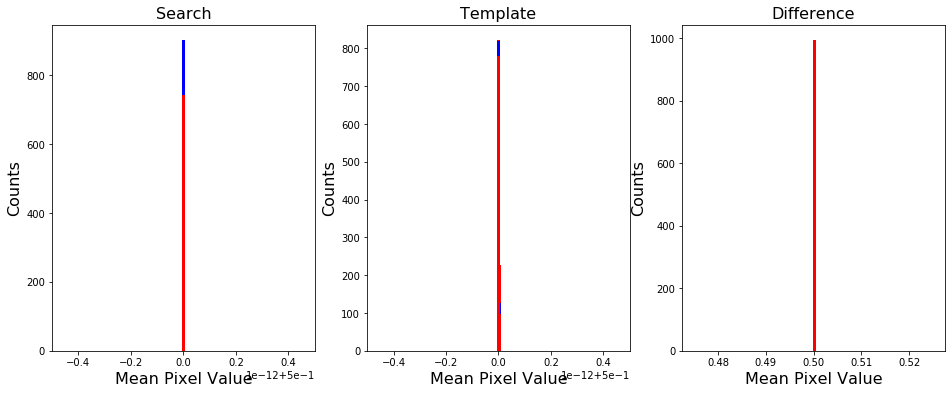

In [202]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_mean, histtype='step', color='blue', label='Class 0', lw=3)
axs[0].hist(class_1_search_mean, histtype='step', color='blue', label='Class 1', lw=3)
axs[0].hist(class_2_search_mean, histtype='step', color='blue', label='Class 2', lw=3)
axs[0].hist(class_3_search_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[0].hist(class_4_search_mean, histtype='step', color='blue', label='Class 4', lw=3)
axs[0].hist(class_5_search_mean, histtype='step', color='blue', label='Class 5', lw=3)
axs[0].hist(class_6_search_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[0].hist(class_7_search_mean, histtype='step', color='blue', label='Class 7', lw=3)
axs[0].hist(class_8_search_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Mean Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_mean, histtype='step', color='blue', label='Class 0', lw=3)
axs[1].hist(class_1_template_mean, histtype='step', color='blue', label='Class 1', lw=3)
axs[1].hist(class_2_template_mean, histtype='step', color='blue', label='Class 2', lw=3)
axs[1].hist(class_3_template_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[1].hist(class_4_template_mean, histtype='step', color='blue', label='Class 4', lw=3)
axs[1].hist(class_5_template_mean, histtype='step', color='blue', label='Class 5', lw=3)
axs[1].hist(class_6_template_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[1].hist(class_7_template_mean, histtype='step', color='blue', label='Class 7', lw=3)
axs[1].hist(class_8_template_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Mean Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_mean, histtype='step', color='blue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_mean, histtype='step', color='blue', label='Class 1', lw=3)
axs[2].hist(class_2_difference_mean, histtype='step', color='blue', label='Class 2', lw=3)
axs[2].hist(class_3_difference_mean, histtype='step', color='red', label='Class 3', lw=3)
axs[2].hist(class_4_difference_mean, histtype='step', color='blue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_mean, histtype='step', color='blue', label='Class 5', lw=3)
axs[2].hist(class_6_difference_mean, histtype='step', color='red', label='Class 6', lw=3)
axs[2].hist(class_7_difference_mean, histtype='step', color='blue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_mean, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_mean, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Mean Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
plt.show()

In [203]:
class_0_search_std = np.std(images0[:,0,:,:], axis=(-1, -2))
class_0_template_std = np.std(images0[:,1,:,:], axis=(-1, -2))
class_0_difference_std = np.std(images0[:,2,:,:], axis=(-1, -2))

class_1_search_std = np.std(images1[:,0,:,:], axis=(-1, -2))
class_1_template_std = np.std(images1[:,1,:,:], axis=(-1, -2))
class_1_difference_std = np.std(images1[:,2,:,:], axis=(-1, -2))

class_2_search_std = np.std(images2[:,0,:,:], axis=(-1, -2))
class_2_template_std = np.std(images2[:,1,:,:], axis=(-1, -2))
class_2_difference_std = np.std(images2[:,2,:,:], axis=(-1, -2))

class_3_search_std = np.std(images3[:,0,:,:], axis=(-1, -2))
class_3_template_std = np.std(images3[:,1,:,:], axis=(-1, -2))
class_3_difference_std = np.std(images3[:,2,:,:], axis=(-1, -2))

class_4_search_std = np.std(images4[:,0,:,:], axis=(-1, -2))
class_4_template_std = np.std(images4[:,1,:,:], axis=(-1, -2))
class_4_difference_std = np.std(images4[:,2,:,:], axis=(-1, -2))

class_5_search_std = np.std(images5[:,0,:,:], axis=(-1, -2))
class_5_template_std = np.std(images5[:,1,:,:], axis=(-1, -2))
class_5_difference_std = np.std(images5[:,2,:,:], axis=(-1, -2))

class_6_search_std = np.std(images6[:,0,:,:], axis=(-1, -2))
class_6_template_std = np.std(images6[:,1,:,:], axis=(-1, -2))
class_6_difference_std = np.std(images6[:,2,:,:], axis=(-1, -2))

class_7_search_std = np.std(images7[:,0,:,:], axis=(-1, -2))
class_7_template_std = np.std(images7[:,1,:,:], axis=(-1, -2))
class_7_difference_std = np.std(images7[:,2,:,:], axis=(-1, -2))

class_8_search_std = np.std(images8[:,0,:,:], axis=(-1, -2))
class_8_template_std = np.std(images8[:,1,:,:], axis=(-1, -2))
class_8_difference_std = np.std(images8[:,2,:,:], axis=(-1, -2))

class_9_search_std = np.std(images9[:,0,:,:], axis=(-1, -2))
class_9_template_std = np.std(images9[:,1,:,:], axis=(-1, -2))
class_9_difference_std = np.std(images9[:,2,:,:], axis=(-1, -2))

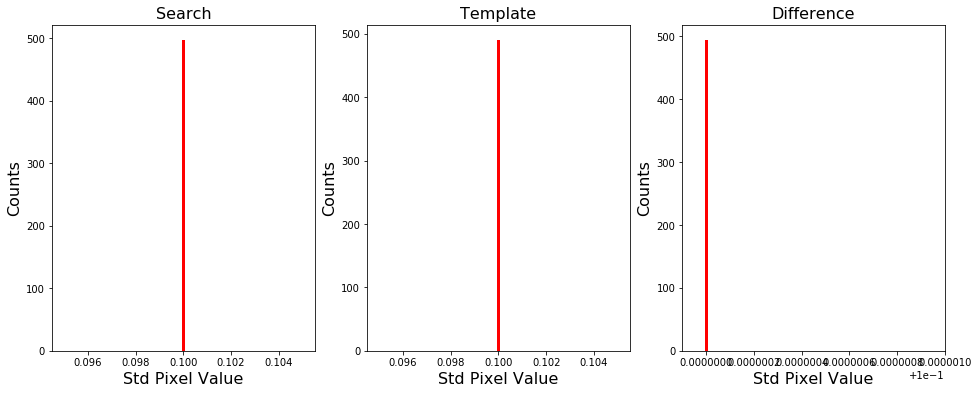

In [254]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
#Search
axs[0].hist(class_0_search_std, histtype='step', color='blue', label='Class 0', lw=3)
axs[0].hist(class_1_search_std, histtype='step', color='blue', label='Class 1', lw=3)
axs[0].hist(class_2_search_std, histtype='step', color='blue', label='Class 2', lw=3)
axs[0].hist(class_3_search_std, histtype='step', color='red', label='Class 3', lw=3)
axs[0].hist(class_4_search_std, histtype='step', color='blue', label='Class 4', lw=3)
axs[0].hist(class_5_search_std, histtype='step', color='blue', label='Class 5', lw=3)
axs[0].hist(class_6_search_std, histtype='step', color='red', label='Class 6', lw=3)
axs[0].hist(class_7_search_std, histtype='step', color='blue', label='Class 7', lw=3)
axs[0].hist(class_8_search_std, histtype='step', color='red', label='Class 8', lw=3)
axs[0].hist(class_9_search_std, histtype='step', color='red', label='Class 9', lw=3)
axs[0].set_title("Search", fontsize=16)
axs[0].set_xlabel("Std Pixel Value", fontsize=16)
axs[0].set_ylabel("Counts", fontsize=16)
#Template
axs[1].hist(class_0_template_std, histtype='step', color='blue', label='Class 0', lw=3)
axs[1].hist(class_1_template_std, histtype='step', color='blue', label='Class 1', lw=3)
axs[1].hist(class_2_template_std, histtype='step', color='blue', label='Class 2', lw=3)
axs[1].hist(class_3_template_std, histtype='step', color='red', label='Class 3', lw=3)
axs[1].hist(class_4_template_std, histtype='step', color='blue', label='Class 4', lw=3)
axs[1].hist(class_5_template_std, histtype='step', color='blue', label='Class 5', lw=3)
axs[1].hist(class_6_template_std, histtype='step', color='red', label='Class 6', lw=3)
axs[1].hist(class_7_template_std, histtype='step', color='blue', label='Class 7', lw=3)
axs[1].hist(class_8_template_std, histtype='step', color='red', label='Class 8', lw=3)
axs[1].hist(class_9_template_std, histtype='step', color='red', label='Class 9', lw=3)
axs[1].set_title("Template", fontsize=16)
axs[1].set_xlabel("Std Pixel Value", fontsize=16)
axs[1].set_ylabel("Counts", fontsize=16)
#Difference
axs[2].hist(class_0_difference_std, histtype='step', color='blue', label='Class 0', lw=3)
axs[2].hist(class_1_difference_std, histtype='step', color='blue', label='Class 1', lw=3)
axs[2].hist(class_2_difference_std, histtype='step', color='blue', label='Class 2', lw=3)
axs[2].hist(class_3_difference_std, histtype='step', color='red', label='Class 3', lw=3)
axs[2].hist(class_4_difference_std, histtype='step', color='blue', label='Class 4', lw=3)
axs[2].hist(class_5_difference_std, histtype='step', color='blue', label='Class 5', lw=3)
axs[2].hist(class_6_difference_std, histtype='step', color='red', label='Class 6', lw=3)
axs[2].hist(class_7_difference_std, histtype='step', color='blue', label='Class 7', lw=3)
axs[2].hist(class_8_difference_std, histtype='step', color='red', label='Class 8', lw=3)
axs[2].hist(class_9_difference_std, histtype='step', color='red', label='Class 9', lw=3)
axs[2].set_title("Difference", fontsize=16)
axs[2].set_xlabel("Std Pixel Value", fontsize=16)
axs[2].set_ylabel("Counts", fontsize=16)
axs[2].set_xlim(0.0999999,0.100001)
plt.show()